In [7]:
# import
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import re
import json
import requests
import mplleaflet

# load APIs
import openrouteservice

import config

from bs4 import BeautifulSoup

In [5]:
csv_name = '176JourneyDataExtract21Aug2019-27Aug2019.csv'
names = pd.read_csv(csv_name, nrows=1).columns
names = names.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

df = pd.read_csv(csv_name,
                 names=names,
                 index_col = 0,
                 skiprows = 1,
                 usecols=['rental_id', 'duration', 'bike_id', 'end_date', 'endstation_id',
                          'start_date', 'startstation_id'])
df.dropna(inplace = True)

# some fields have seconds added, some don't.
# it's faster to slice strings first [:16] and then convert using specified format
df.start_date = pd.to_datetime(df.start_date.str[:16], format="%d/%m/%Y %H:%M")
df.end_date = pd.to_datetime(df.end_date.str[:16], format="%d/%m/%Y %H:%M")

# convert duration to minutes
df.duration = df.duration/60

In [6]:
print(df.shape)
df.head()

(242194, 6)


,duration,bike_id,end_date,endstation_id,start_date,startstation_id
rental_id,,,,,,
90477391,5.0,379,2019-08-23 22:57:00,109,2019-08-23 22:52:00,77
90477176,7.0,379,2019-08-23 22:45:00,77,2019-08-23 22:38:00,109
90475826,18.0,13429,2019-08-23 21:36:00,192,2019-08-23 21:18:00,194
90496646,5.0,15653,2019-08-24 16:17:00,715,2019-08-24 16:12:00,464
90511107,4.0,3278,2019-08-25 01:46:00,715,2019-08-25 01:42:00,464


In [7]:
df.describe(include='all')

,duration,bike_id,end_date,endstation_id,start_date,startstation_id
count,242194.000000,242194.000000,242194,242194.000000,242194,242194.000000
unique,NaN,NaN,9711,NaN,9682,NaN
top,NaN,NaN,2019-08-27 18:01:00,NaN,2019-08-27 18:03:00,NaN
freq,NaN,NaN,109,NaN,114,NaN
first,NaN,NaN,2019-08-21 00:06:00,NaN,2019-08-21 00:00:00,NaN
last,NaN,NaN,2019-08-27 23:59:00,NaN,2019-08-27 23:57:00,NaN
mean,23.834864,9096.404787,NaN,387.529014,NaN,387.292621
std,66.777906,5071.170281,NaN,244.238187,NaN,243.972635
min,1.000000,2.000000,NaN,1.000000,NaN,1.000000
25%,9.000000,4690.000000,NaN,184.000000,NaN,183.000000


In [8]:
df.dtypes

duration                  float64
bike_id                     int64
end_date           datetime64[ns]
endstation_id               int64
start_date         datetime64[ns]
startstation_id             int64
dtype: object

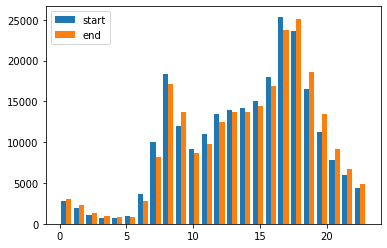

In [9]:
plt.hist([df.start_date.dt.hour, df.end_date.dt.hour], bins=24, label=['start','end'])
plt.legend(loc='upper left')
plt.show()

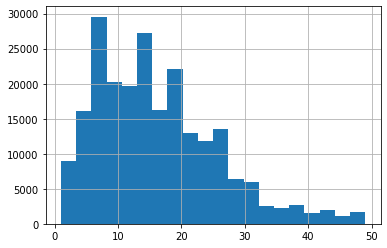

In [11]:
(df.duration[df.duration<50]).hist(bins= 20)
plt.show()

# Parse links

In [4]:
def get_links_list(online=False):
    links_list = []

    if online: 
        url = 'https://cycling.data.tfl.gov.uk/'
        html_page = urllib.request.urlopen(url)
    else:
        html_page = open("cycling.data.tfl.gov.uk.html")   

    soup = BeautifulSoup(html_page)

    for link in soup.findAll('a'):
        href = link.get('href')
        if 'usage-stats' in href and href.endswith('csv'):
            links_list.append(href)

    return links_list

get_links_list()

FileNotFoundError: [Errno 2] No such file or directory: 'cycling.data.tfl.gov.uk.html'

# Stations location

In [8]:
bikes_location_url = f"https://api.tfl.gov.uk/BikePoint?app_id={config.tfl_app_id}&app_key={config.tfl_app_key}"
bikes_location_url = "https://api.tfl.gov.uk/BikePoint"
cred = {'app_id':config.tfl_app_id, 'app_key':config.tfl_app_key}
r = requests.get(url = bikes_location_url, params = cred)

data = r.json()

station_loc = []

for jsonobject in data:
    features = {
        'id': jsonobject['id'][11:],
        'commonName': jsonobject['commonName'],
        'longitude': jsonobject['lon'],
        'latitude': jsonobject['lat']
    }

#     {'TerminalName': '001023',
#      'Installed': 'true',
#      'Locked': 'false',
#      'InstallDate': '1278947280000',
#      'RemovalDate': '',
#      'Temporary': 'false',
#      'NbBikes': '7',
#      'NbEmptyDocks': '12',
#      'NbDocks': '19'}
    features.update(dict([[d['key'], d['value']] for d in jsonobject['additionalProperties']]))
    station_loc.append(features)

station_loc = pd.DataFrame.from_dict(station_loc).set_index('id')
station_loc.columns = [re.sub('(?!^)([A-Z]+)', r'_\1', x).lower() for x in station_loc.columns]
station_loc['install_date'] = pd.to_datetime(station_loc['install_date'],unit='ms')
station_loc['removal_date'] = pd.to_datetime(station_loc['removal_date'],unit='ms')

In [9]:
station_loc.head()

,common_name,longitude,latitude,terminal_name,installed,locked,install_date,removal_date,temporary,nb_bikes,nb_empty_docks,nb_docks
id,,,,,,,,,,,,
1,"River Street , Clerkenwell",-0.109970,51.529163,001023,true,false,2010-07-12 15:08:00,NaT,false,6,13,19
2,"Phillimore Gardens, Kensington",-0.197574,51.499606,001018,true,false,2010-07-08 10:43:00,NaT,false,15,22,37
3,"Christopher Street, Liverpool Street",-0.084605,51.521283,001012,true,false,2010-07-04 10:46:00,NaT,false,1,31,32
4,"St. Chad's Street, King's Cross",-0.120973,51.530059,001013,true,false,2010-07-04 10:58:00,NaT,false,21,2,23
9,"New Globe Walk, Bankside",-0.096440,51.507385,001015,true,false,2010-07-04 11:19:00,NaT,false,18,1,19


In [45]:
# plt.hold(True)
cartodb_dark_matter = (
    'https://a.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png',
    '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> &copy; <a href="http://cartodb.com/attributions">CARTO</a>'
)

fig = plt.gcf()
fig.set_size_inches(7, 5)
plt.plot(station_loc.longitude, station_loc.latitude, 'r.') # Draw red dots
mplleaflet.display(tiles=cartodb_dark_matter) #'cartodb_positron'

/home/mikolaj/dev/Tfl/tfl/lib/python3.6/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Predict road

In [17]:
# import openrouteservice

coords = ((8.34234,48.23424),(8.34423,48.26424))
client = openrouteservice.Client(key=config.ors_key) # Specify your personal API key
routes = client.directions(coords, profile='cycling-regular')
print(routes)

{'bbox': [8.327707, 48.233135, 8.345244, 48.263552], 'routes': [{'summary': {'distance': 5236.8, 'duration': 1316.5}, 'segments': [{'distance': 5236.8, 'duration': 1316.5, 'steps': [{'distance': 537.6, 'duration': 161.3, 'type': 11, 'instruction': 'Head southwest', 'name': '-', 'way_points': [0, 13]}, {'distance': 350.0, 'duration': 73.4, 'type': 6, 'instruction': 'Continue straight', 'name': '-', 'way_points': [13, 25]}, {'distance': 14.3, 'duration': 2.9, 'type': 1, 'instruction': 'Turn right onto Sulzbacher Straße, K 5528', 'name': 'Sulzbacher Straße, K 5528', 'way_points': [25, 26]}, {'distance': 321.2, 'duration': 64.2, 'type': 6, 'instruction': 'Continue straight onto Sulzbacher Straße, K 5528', 'name': 'Sulzbacher Straße, K 5528', 'way_points': [26, 35]}, {'distance': 492.6, 'duration': 98.5, 'type': 4, 'instruction': 'Turn slight left onto Sulzbacher Straße, K 5528', 'name': 'Sulzbacher Straße, K 5528', 'way_points': [35, 50]}, {'distance': 265.2, 'duration': 59.7, 'type': 13, 

In [23]:
# sample data
sample_data = station_loc[['longitude','latitude']][0:2]
coords = tuple(sample_data.itertuples(index=False, name=None))

client = openrouteservice.Client(key=config.ors_key) # Specify your personal API key
routes = client.directions(coords, profile='cycling-regular')
print(routes)

{'bbox': [-0.197864, 51.499584, -0.109926, 51.529119], 'routes': [{'summary': {'distance': 8459.9, 'duration': 1714.5}, 'segments': [{'distance': 8459.9, 'duration': 1714.5, 'steps': [{'distance': 94.9, 'duration': 20.4, 'type': 11, 'instruction': 'Head southwest on River Street', 'name': 'River Street', 'way_points': [0, 9]}, {'distance': 31.9, 'duration': 6.4, 'type': 3, 'instruction': 'Turn sharp right onto Lloyd Street', 'name': 'Lloyd Street', 'way_points': [9, 10]}, {'distance': 72.3, 'duration': 14.5, 'type': 0, 'instruction': 'Turn left onto Lloyd Square', 'name': 'Lloyd Square', 'way_points': [10, 11]}, {'distance': 248.8, 'duration': 49.8, 'type': 6, 'instruction': 'Continue straight onto Wharton Street', 'name': 'Wharton Street', 'way_points': [11, 16]}, {'distance': 63.7, 'duration': 12.7, 'type': 1, 'instruction': "Turn right onto King's Cross Road, A201", 'name': "King's Cross Road, A201", 'way_points': [16, 19]}, {'distance': 47.6, 'duration': 9.5, 'type': 0, 'instructio

In [30]:
json.loads(json.dumps(routes))

{'bbox': [-0.197864, 51.499584, -0.109926, 51.529119],
 'routes': [{'summary': {'distance': 8459.9, 'duration': 1714.5},
   'segments': [{'distance': 8459.9,
     'duration': 1714.5,
     'steps': [{'distance': 94.9,
       'duration': 20.4,
       'type': 11,
       'instruction': 'Head southwest on River Street',
       'name': 'River Street',
       'way_points': [0, 9]},
      {'distance': 31.9,
       'duration': 6.4,
       'type': 3,
       'instruction': 'Turn sharp right onto Lloyd Street',
       'name': 'Lloyd Street',
       'way_points': [9, 10]},
      {'distance': 72.3,
       'duration': 14.5,
       'type': 0,
       'instruction': 'Turn left onto Lloyd Square',
       'name': 'Lloyd Square',
       'way_points': [10, 11]},
      {'distance': 248.8,
       'duration': 49.8,
       'type': 6,
       'instruction': 'Continue straight onto Wharton Street',
       'name': 'Wharton Street',
       'way_points': [11, 16]},
      {'distance': 63.7,
       'duration': 12.7,
  

# Weather and air pollution

In [ ]:
# pip install pyowm
owm = pyowm.OWM('your-API-key')  # You MUST provide a valid API key

# Search for current weather in London (Great Britain)
observation = owm.weather_at_place('London,GB')
w = observation.get_weather()
print(w)                      # <Weather - reference time=2013-12-18 09:20,
                              # status=Clouds>

# Weather details
w.get_wind()                  # {'speed': 4.6, 'deg': 330}
w.get_humidity()              # 87
w.get_temperature('celsius')  # {'temp_max': 10.5, 'temp': 9.7, 'temp_min': 9.0}

w.to_JSON()